# Time series analysis of Google Trends for "Fourier Transform"

In [ ]:
%pip install pytrends

In [1]:
from pytrends.request import TrendReq
import pandas as pd

## Get Google trends data

In [2]:
pytrends = TrendReq(hl='en-US', tz=360)

In [3]:
keywords = ['Fourier Transform']
pytrends.build_payload(keywords, cat=0, timeframe='all', geo='', gprop='')


In [4]:
trends_df=pytrends.interest_over_time()


/usr/local/python/3.12.1/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Note the [maintainer stepped down](https://github.com/GeneralMills/pytrends/issues/636) and the repo is archived. They raise serious concerns about data quality but suggest trendspy as an alternative.

<Axes: xlabel='date'>

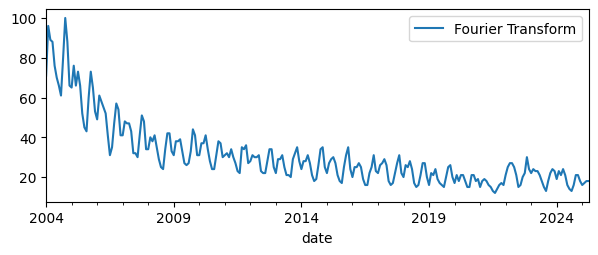

In [5]:
trends_df[~trends_df.isPartial].plot(figsize=[7,2.5])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

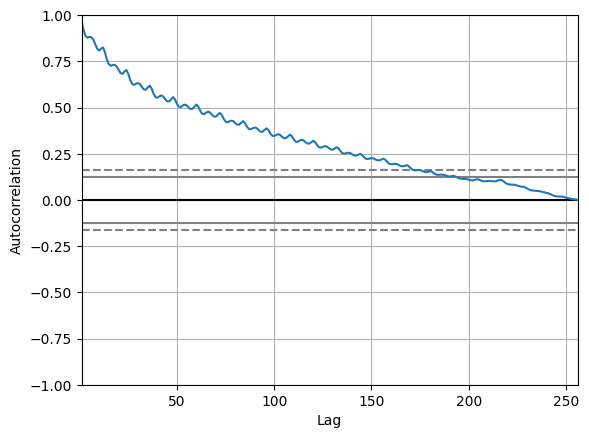

In [8]:
pd.plotting.autocorrelation_plot(trends_df[~trends_df.isPartial].dropna())

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

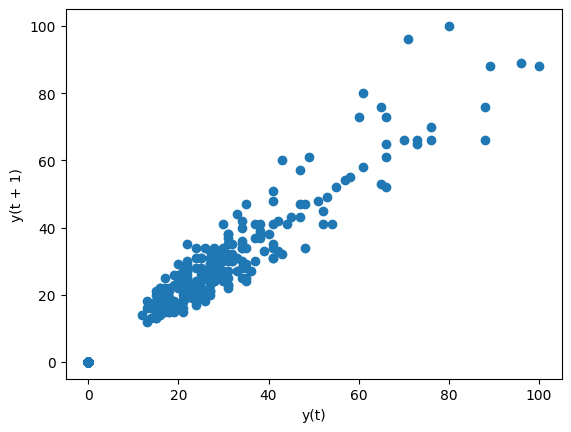

In [12]:
pd.plotting.lag_plot(trends_df[~trends_df.isPartial].dropna(),lag=1)

Periodicity barely stands out in autocorrelation plot against decaying trend. A lag of 1 is the classic use of the lag plot as a test for randomness, as described in the NIST Engineering statistics handbook. In this case the data is definitely not random.

## Diff to remove slow decay, keep periodicity

<Axes: xlabel='date'>

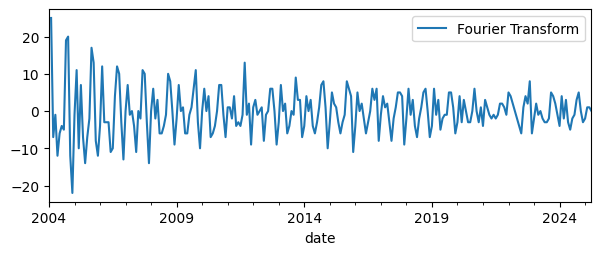

In [22]:
trends_df[~trends_df.isPartial].diff().plot(figsize=[7,2.5])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

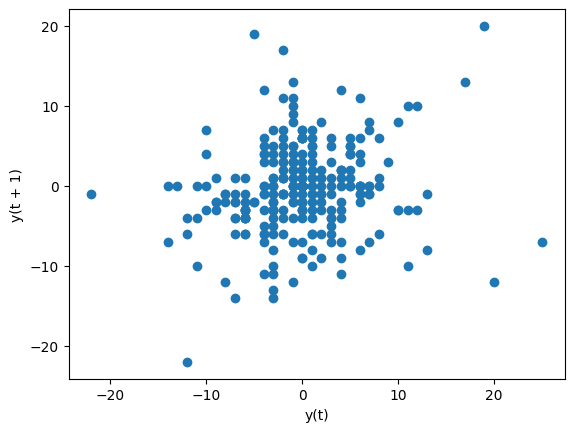

In [14]:
pd.plotting.lag_plot(trends_df[~trends_df.isPartial].diff().dropna(),lag=1)

This time the lag 1 plot does show randomness.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

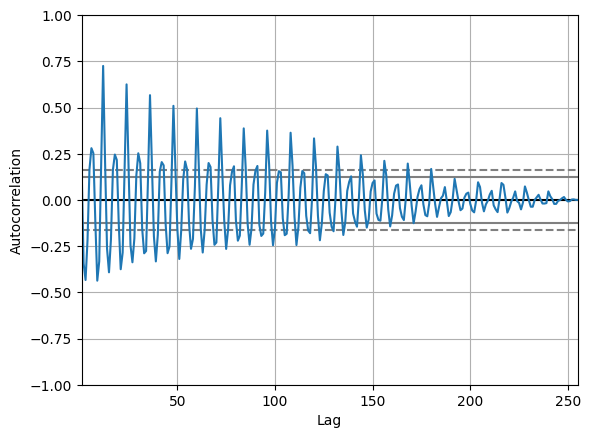

In [15]:
pd.plotting.autocorrelation_plot(trends_df[~trends_df.isPartial].diff().dropna())

Monthly data. High peaks: 12, 24, 36, 48... Smaller peaks half way through. 

<Axes: xlabel='y(t)', ylabel='y(t + 12)'>

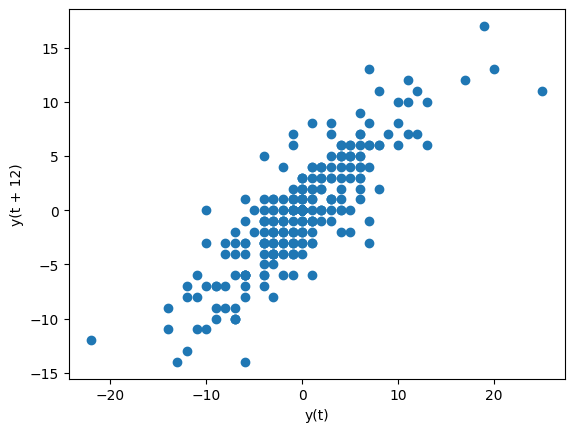

In [16]:
pd.plotting.lag_plot(trends_df[~trends_df.isPartial].diff().dropna(),lag=12)

The lag plots for 12 and 6 months lag further confirm the relationship.

<Axes: xlabel='y(t)', ylabel='y(t + 6)'>

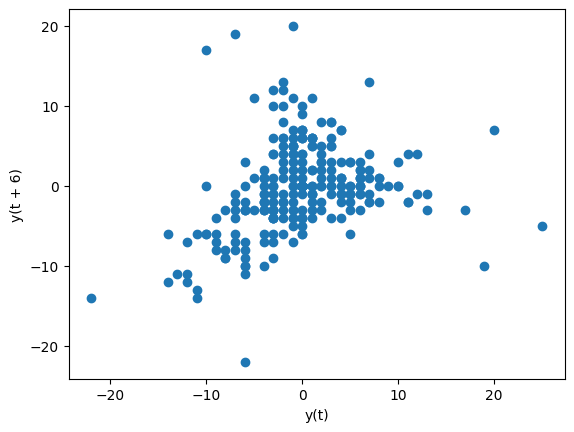

In [17]:
pd.plotting.lag_plot(trends_df[~trends_df.isPartial].diff().dropna(),lag=6)

Inspired from a Linked In post by Kunpeng (KP) Liao. Released under the GPL 3.0 Licence.  
https://github.com/stelios-c/sig_proc/blob/main/timeseries.ipynb